### **Add pre-installed package path & load packages:**

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [2]:
library("dplyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
#library(glmnet)
library(pROC)
library(corrplot)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


corrplot 0.92 loaded



### **Change working directory:**

In [3]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/data"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/data"

### **Load data:**

#### **Phenotypes + proteomic data:**

In [4]:
file <- "data_int_clean.csv"
data <- fread(file)

In [5]:
head(data)

IID,delirium_incident,sex,age_at_collection,BMI,age,A1BG,AAMDC,AARSD1,ABCA2,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000071,0,0,59.17,27.3034,74.3,-0.5636206,-0.2319053,1.5596201,0.9791327,⋯,-0.03639606,0.37683436,0.43215965,0.8766984,-0.7916236,-0.3159349,-0.6431585,1.3083066,-0.06429908,-1.31766789
1000303,0,1,63.82,30.0092,72.1,0.5763088,0.7244458,1.2263775,-1.2518762,⋯,1.95985919,-0.07788302,1.43767332,-0.3975205,-0.7840327,1.0690744,0.3421107,0.4856861,1.15774521,-0.53523046
1000629,0,0,54.93,25.6935,67.6,1.6870052,-0.1801851,1.6281861,2.3867634,⋯,-0.58808635,0.89976191,0.36642887,-0.6560515,0.5469614,-0.5574226,0.6469867,-0.5861254,0.57264191,0.71158105
1000647,0,0,68.51,22.7918,76.7,0.6556707,-0.5592169,0.2541999,1.4214640,⋯,-0.82985399,0.36852319,-0.06868455,0.1275109,0.7748272,-0.5330613,-1.0631794,0.6328081,-0.47225460,1.62257797
1000757,0,0,57.94,25.6568,72.2,1.1665682,-0.7812693,-1.7329621,0.6687664,⋯,1.10886727,-0.74698657,0.81184418,-0.3673321,0.6455204,-0.2965854,1.5817164,1.6487562,0.08281206,0.08373647
1000900,0,0,47.55,30.9234,61.1,-0.8259067,0.2858929,0.2346379,-0.8890541,⋯,0.32150786,0.52036175,-0.52551069,-0.4055505,0.7377842,-0.2601942,-0.7418215,0.1521247,-1.16558340,-1.29968364


### **QC & mean impute missing values:**

In [6]:
variables  <- c("IID", "delirium_incident", "sex", "age_at_collection", "BMI", "age") # non-protein columns
prot_names <- names(data)[!names(data) %in% variables] # protein names
n_prot     <- length(prot_names) # #of proteins
n_prot

[1] 2919

In [7]:
## find proteins with < 80% nonmissing values

# produce table with % non-missing per protein
nmiss_prot <- data %>% select(all_of(prot_names)) %>% summarise(across(everything(), ~ sum(!is.na(.)) / n_prot)) 
# protein names with < 80% nonmissing values
low_nmiss_prot_names <-  names(nmiss_prot)[nmiss_prot <  0.8] 
cat("proteins with <80% non-missing rate to be excluded:", low_nmiss_prot_names)

# mean impute NAs in BMI & 
# mean impute NAs in remaining proteins &
# exlcude proteins with <80% non-missing rate 

data_qc <-
data %>% 
    mutate(BMI = ifelse(is.na(BMI), mean(BMI,na.rm = T), BMI)) %>%
    mutate(across(all_of(prot_names), ~ ifelse(is.na(.), mean(., na.rm = T), .) )) %>% 
    select(-c(all_of(low_nmiss_prot_names)))

proteins with <80% non-missing rate to be excluded: 

### **Proteins correlation plot:**

In [8]:
# correlation matrix (prearson's correlation)
prot_corr_mat <- data_qc %>% select(all_of(prot_names[!prot_names %in% low_nmiss_prot_names])) %>% cor()

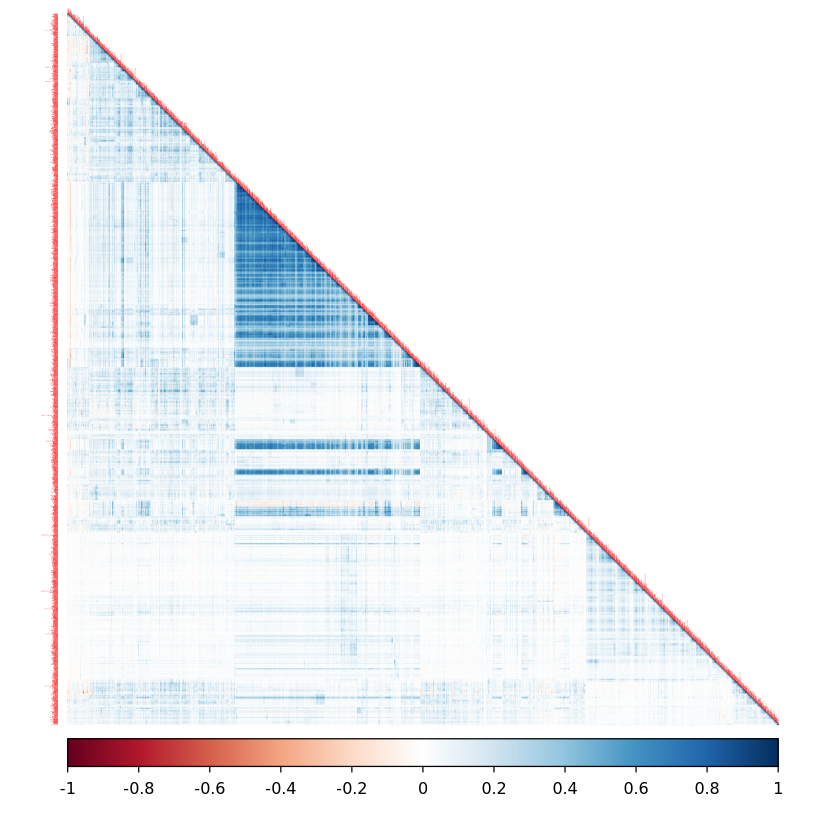

In [9]:
# correlation plot
corrplot(prot_corr_mat, method="color", type="lower", order='hclust', tl.cex=0.05)

No. of PCs that explain 90% of cumulative variance of the 2919 proteins: 1343

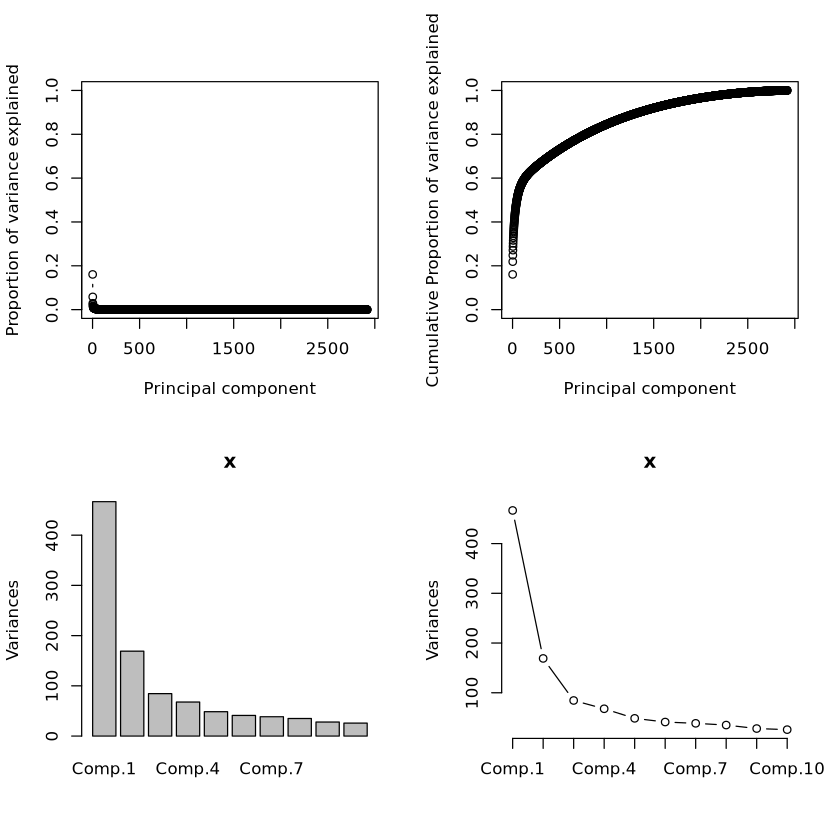

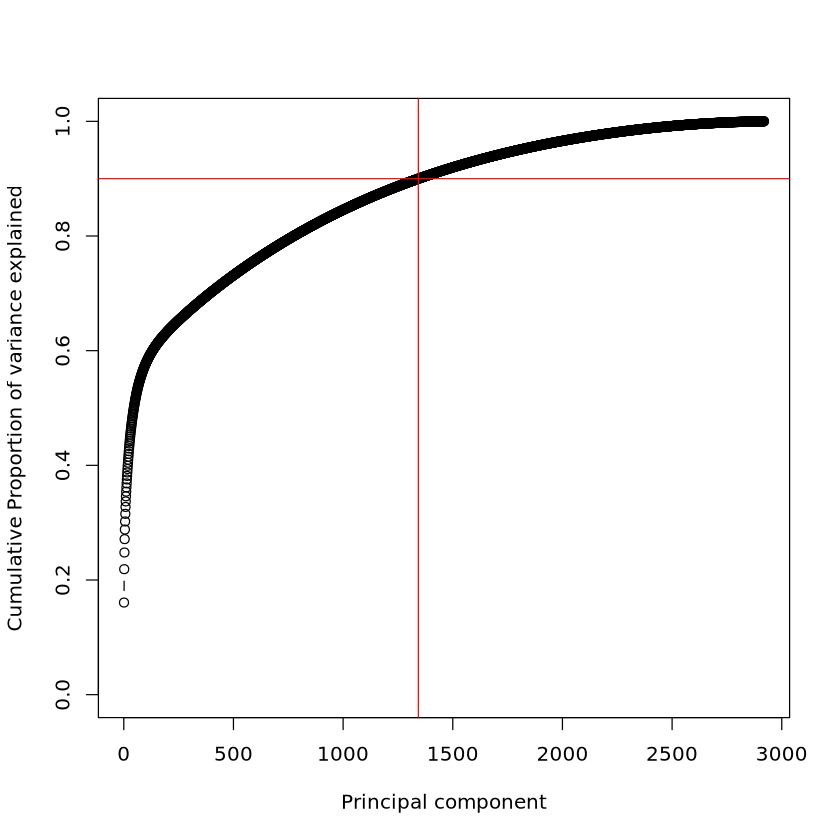

In [73]:
## proteins' pca
#prot_pca <- princomp(prot_corr_mat, cor = T)
pca_df   <- data_qc %>% select(all_of(prot_names[!prot_names %in% low_nmiss_prot_names])) #df with only proteins
prot_pca <- princomp(pca_df) 

pcaCharts <- function(x) {
    x.var <- x$sdev ^ 2
    x.pvar <- x.var/sum(x.var)
    #print("proportions of variance:")
    #print(x.pvar)
    
    par(mfrow=c(2,2))
    plot(x.pvar,xlab="Principal component", ylab="Proportion of variance explained", ylim=c(0,1), type='b')
    plot(cumsum(x.pvar),xlab="Principal component", ylab="Cumulative Proportion of variance explained", ylim=c(0,1), type='b')
    screeplot(x)
    screeplot(x,type="l")
    par(mfrow=c(1,1))
}

pcaCharts(prot_pca)

# PCs that explain 90% of variance cumulatively:
percent <- 0.9
x.var  <- prot_pca$sdev ^ 2
x.pvar <- x.var/sum(x.var)
pcmax  <- cumsum(x.pvar)[cumsum(x.pvar)<percent] %>% length 
cat(paste0("No. of PCs that explain ", percent*100, "% of cumulative variance of the ", ncol(pca_df), " proteins: ", pcmax))

plot(cumsum(x.pvar),xlab="Principal component", ylab="Cumulative Proportion of variance explained", 
     ylim=c(0,1), type='b')
abline(h=percent, v=pcmax, col="red")



### **Make time to event variable for cox LASSO:**

see: https://glmnet.stanford.edu/articles/Coxnet.html <br>
***y*** is an **n×2** matrix, with a column **"time"** of failure/censoring times, and **"status"** a 0/1 indicator, with 1 meaning the time is a failure time, and 0 a censoring time. 

In [8]:
## make time variable (assessment to first delirium incidence (cases) or censoring/death (controls))
## + status variable

# age = age of death for dead (without delirium)
# age = age of first delirium for delirium cases
# age = age of cencoring for all else

data_qc <-
data_qc %>% 
    mutate(time = (age - age_at_collection)) %>%    # time_to_event outcome
    mutate(status = ifelse(delirium_incident ==1, 1, 0)) %>%  # status: 1=event; 0=censored
    select('IID', 'delirium_incident', 'time', 'status','sex', 'age_at_collection', 'BMI', all_of(prot_names)) # drop variables not used
head(data_qc)

IID,delirium_incident,time,status,sex,age_at_collection,BMI,A1BG,AAMDC,AARSD1,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000071,0,15.13,0,0,59.17,27.3034,-0.5636206,-0.2319053,1.5596201,⋯,-0.03639606,0.37683436,0.43215965,0.8766984,-0.7916236,-0.3159349,-0.6431585,1.3083066,-0.06429908,-1.31766789
1000303,0,8.28,0,1,63.82,30.0092,0.5763088,0.7244458,1.2263775,⋯,1.95985919,-0.07788302,1.43767332,-0.3975205,-0.7840327,1.0690744,0.3421107,0.4856861,1.15774521,-0.53523046
1000629,0,12.67,0,0,54.93,25.6935,1.6870052,-0.1801851,1.6281861,⋯,-0.58808635,0.89976191,0.36642887,-0.6560515,0.5469614,-0.5574226,0.6469867,-0.5861254,0.57264191,0.71158105
1000647,0,8.19,0,0,68.51,22.7918,0.6556707,-0.5592169,0.2541999,⋯,-0.82985399,0.36852319,-0.06868455,0.1275109,0.7748272,-0.5330613,-1.0631794,0.6328081,-0.47225460,1.62257797
1000757,0,14.26,0,0,57.94,25.6568,1.1665682,-0.7812693,-1.7329621,⋯,1.10886727,-0.74698657,0.81184418,-0.3673321,0.6455204,-0.2965854,1.5817164,1.6487562,0.08281206,0.08373647
1000900,0,13.55,0,0,47.55,30.9234,-0.8259067,0.2858929,0.2346379,⋯,0.32150786,0.52036175,-0.52551069,-0.4055505,0.7377842,-0.2601942,-0.7418215,0.1521247,-1.16558340,-1.29968364


### **Split training (80%) and test set (20%):**

In [9]:
# define fraction for training set
set.seed(11)
frac = 0.8
# get random iids for training set
training_iids <- data_qc %>% sample_frac(frac) %>% pull(IID)
# subset training data set
training_data <- data_qc %>% filter(IID %in% training_iids)
# subset test data set
test_data     <- data_qc %>% filter(!(IID %in% training_iids))
# see cases / controls in sets
cat("Training set: ")
training_data %>% group_by(delirium_incident) %>% summarise(n = n()) %>% mutate(freq = round(n/sum(n),3))
cat("Test set: ")
test_data %>% group_by(delirium_incident) %>% summarise(n = n()) %>% mutate(freq = round(n/sum(n),3))

Training set: 

delirium_incident,n,freq
<int>,<int>,<dbl>
0,25687,0.983
1,435,0.017


Test set: 

delirium_incident,n,freq
<int>,<int>,<dbl>
0,6424,0.984
1,106,0.016


### **Subsample controls to 50% prevelance:**

In [31]:
## training set
set.seed(11)
# iids of cases 
iids_cases_training <- training_data %>% filter(delirium_incident==1) %>% pull(IID)
# no of cases in training set
n_cases_training  <- length(iids_cases_training)
# sample random control iids from training set, so that n_cases = n_controls
iids_sub_controls_training <- training_data %>% filter(delirium_incident==0) %>% sample_n(n_cases_training) %>% pull(IID)
# subsambe cases + random controls 
training_data_sub <- training_data %>% filter(IID %in% c(iids_cases_training, iids_sub_controls_training))
# summary
cat("Training set - subsampled: ")
training_data_sub %>% group_by(delirium_incident) %>% summarise(n = n()) %>% mutate(freq = round(n/sum(n),3))


Training set - subsampled: 

delirium_incident,n,freq
<int>,<int>,<dbl>
0,435,0.5
1,435,0.5


In [41]:
## test set
set.seed(11)
# iids of cases 
iids_cases_test <- test_data %>% filter(delirium_incident==1) %>% pull(IID)
# no of cases in test set
n_cases_test  <- length(iids_cases_test)
# sample random control iids from test set, so that n_cases = n_controls
iids_sub_controls_test <- test_data %>% filter(delirium_incident==0) %>% sample_n(n_cases_test) %>% pull(IID)
# subsambe cases + random controls 
test_data_sub <- test_data %>% filter(IID %in% c(iids_cases_test, iids_sub_controls_test))
# summmary
cat("Test set - subsampled: ")
test_data_sub %>% group_by(delirium_incident) %>% summarise(n = n()) %>% mutate(freq = round(n/sum(n),3))

Test set - subsampled: 

delirium_incident,n,freq
<int>,<int>,<dbl>
0,106,0.5
1,106,0.5


In [50]:
## write sunsample training and test sets:
write.table(test_data_sub, "test_data_subsample_1on1.csv", row.names=F, col.names=T, quote=T, sep=",")
write.table(training_data_sub, "training_data_subsample_1on1.csv", row.names=F, col.names=T, quote=T, sep=",")

## write full training and test sets:
write.table(test_data, "test_data.csv", row.names=F, col.names=T, quote=T, sep=",")
write.table(training_data, "training_data.csv", row.names=F, col.names=T, quote=T, sep=",")


### **Run LASSO model: *delirium_incident ~ covariates + proteins***

Sources:
- https://www.statology.org/lasso-regression-in-r/ (basic r code)
- http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/ (for binary outcomes code)
- https://glmnet.stanford.edu/articles/glmnet.html (glmnet documentation: for penalty.factor option - fix to 0 for covariates)

In [6]:
# load cv.lasso.w, data from files (after cv.lasso is run)
#cv.lasso.w <- readRDS("../data_lasso/cv.lasso.w.rds")
#training_data <- readRDS("../data_lasso/training_data.rds")
#test_data <- readRDS("../data_lasso/test_data.rds")


In [32]:
# define response variable 
Y.train <- training_data$delirium_incident # training set
Y.test  <- test_data$delirium_incident     # test set

# define matrix of predictor variables 
#X <- data.matrix(training_data[,-c("IID","delirium_incident")])
X.train <- training_data[,-c("IID","delirium_incident","time","status")]
X.test  <- test_data[,-c("IID","delirium_incident","time","status")] 
X       <- makeX(X.train, X.test)

ERROR: Error in makeX(X.train, X.test): could not find function "makeX"


In [11]:
# set penalty factors: 0 to demographic covariates, so they don't get penalised by lasso model
p.fac <- rep(1, ncol(X$x))
p.fac[1:3] <- 0 # 1:3 are the col. positions in X matrix


ERROR: Error in eval(expr, envir, enclos): object 'X' not found


#### **Model weights:**

In [ ]:
## define weights: 
# for each obs in Y.train: 1 - (#of class members /#of total)
# see here: https://stats.stackexchange.com/questions/232228/cross-validation-for-uneven-groups-using-cv-glmnet
# and here: https://glmnet.stanford.edu/reference/glmnet.html
fraction <- table(Y.train) / length(Y.train)
weights  <- 1 - fraction[as.character(Y.train)]


#### **Training set:**

In [ ]:
# perform k-fold cross-validation to find optimal lambda value (slow)
cv.lasso.w <- cv.glmnet(X$x,     # predictors' matrix
                        Y.train, # response variable
                        alpha = 1,           # corresponds to lasso model
                        family = "binomial", # for logistic regression
                        weights = weights,   # observation's weights
                        standardize= T,      # (default) perform standardisation of x
                        penalty.factor = p.fac, # user-defined penalty factors
                        trace.it = TRUE)     # progress bar


In [ ]:
# basic info for the cv.glmnet object
print(cv.lasso.w)
# plot lambdas
plot(cv.lasso.w)
# find optimal lambda value that minimizes test loss function 
cv.lasso.w$lambda.min
cv.lasso.w$lambda.1se

In [ ]:
# final model with best.lambda
lasso.best.lambda.w <- glmnet(X$x, 
                              Y.train, 
                              alpha = 1, 
                              family = "binomial", 
                              lambda = cv.lasso.w$lambda.min,
                              weights = as.vector(weights),   
                              standardize= T,      
                              penalty.factor = p.fac, 
                              trace.it = TRUE)

# final model with 1se best lambda
lasso.1se.lambda.w <- glmnet(X$x, 
                              Y.train, 
                              alpha = 1, 
                              family = "binomial", 
                              lambda = cv.lasso.w$lambda.1se,
                              weights = as.vector(weights),   
                              standardize= T,      
                              penalty.factor = p.fac, 
                              trace.it = TRUE)


#### **Test set:**

In [ ]:
## Make prediction on test data
# performance measures on test set
lasso.full.min.w.performance <-  assess.glmnet(lasso.best.lambda.w, newx = X$xtest , newy = Y.test, family = "binomial")
lasso.full.min.w.performance$auc
lasso.full.1se.w.performance <-  assess.glmnet(lasso.1se.lambda.w, newx = X$xtest , newy = Y.test, family = "binomial")
lasso.full.1se.w.performance$auc
# 0.801179 for min lambda
# 0.7818998 for 1.se lambda

# roc curve 
roc.full.w <- roc.glmnet(lasso.1se.lambda.w, newx=X$xtest, newy = Y.test)
plot(roc.full.w)

# confusion matrix 
cnf.full.w <- confusion.glmnet(lasso.1se.lambda.w, newx=X$xtest, newy = Y.test)
cnf.full.w

#         True
#Predicted    0   1 Total
#    0     4311  23  4334
#    1     2113  83  2196
#    Total 6424 106  6530
#
# Percent Correct:  0.6729


# predict outcomes (change thresholds) (0=control, 1=case)
probs.w     <-predict(lasso.best.lambda.w, newx = X$xtest, type = "response") # predicted probabilities
probs.w.1se <-predict(lasso.1se.lambda.w, newx = X$xtest, type = "response") # 1se model

thres=0.5 
pred.w <- ifelse(probs.w > thres, "1", "0") %>% as.factor # convert to predicted outcome at thres threshold
library(caret)
confusionMatrix(pred.w, as.factor(Y.test), positive="1", mode = "everything")

### **Run Cox LASSO model: *delirium_incident ~ covariates + proteins***

In [45]:
# define response variable 
Y.cph.train <- training_data %>% select(time, status) %>% data.matrix # training set
Y.cph.test  <- test_data %>% select(time, status) %>% data.matrix     # test set

# define matrix of predictor variables 
#X <- data.matrix(training_data[,-c("IID","delirium_incident")])
X.cph.train <- data.matrix(training_data[,-c("IID","delirium_incident","time","status")])
X.cph.test  <- data.matrix(test_data[,-c("IID","delirium_incident","time","status")])


In [1]:
# set penalty factors: 0 to demographic covariates, so they don't get penalised by lasso model
p.fac <- rep(1, ncol(X.cph.train))
p.fac[1:3] <- 0 # 1:3 are the col. positions in X matrix

## define weights: 
# for each obs in Y.train: 1 - (#of class members /#of total)
# see here: https://stats.stackexchange.com/questions/232228/cross-validation-for-uneven-groups-using-cv-glmnet
# and here: https://glmnet.stanford.edu/reference/glmnet.html
fraction <- table(Y.cph.train[,2]) / length(Y.cph.train[,2])
weights  <- 1 - fraction[as.character(Y.cph.train[,2])]


ERROR: Error in eval(expr, envir, enclos): object 'X.cph.train' not found


#### **Training set:**

In [ ]:
# perform k-fold cross-validation to find optimal lambda value (very slow)
cv.lasso.cph <- cv.glmnet(X.cph.train,     # predictors' matrix
                          Y.cph.train,     # response variable
                          alpha = 1,           # corresponds to lasso model
                          family = "cox",      # for cox model
                          weights = weights,   # observation's weights
                          standardize= T,      # (default) perform standardisation of x
                          penalty.factor = p.fac, # user-defined penalty factors
                          trace.it = TRUE)     # progress bar


In [ ]:
# load:
cv.lasso.cph <- readRDS("../data_lasso/cv.lasso.cph.rds")
training_data <- readRDS("../data_lasso/training_data.rds")
test_data <- readRDS("../data_lasso/test_data.rds")

# basic info for the cv.glmnet object
print(cv.lasso.cph)
# plot lambdas
plot(cv.lasso.cph)
# find optimal lambda value that minimizes test loss function 
cv.lasso.cph$lambda.min
cv.lasso.cph$lambda.1se

#### **Test set:**

In [ ]:
# final model with best.lambda
lasso.best.lambda.w <- glmnet(X$x, 
                              Y.train, 
                              alpha = 1, 
                              family = "binomial", 
                              lambda = cv.lasso.w$lambda.min,
                              weights = as.vector(weights),   
                              standardize= T,      
                              penalty.factor = p.fac, 
                              trace.it = TRUE)

# final model with 1se best lambda
lasso.1se.lambda.w <- glmnet(X$x, 
                              Y.train, 
                              alpha = 1, 
                              family = "binomial", 
                              lambda = cv.lasso.w$lambda.1se,
                              weights = as.vector(weights),   
                              standardize= T,      
                              penalty.factor = p.fac, 
                              trace.it = TRUE)

### **Run null Cox LASSO model: delirium_incident ~ covariates**

In [ ]:
# define response variable (same with the full model)
Y.cph.train <- training_data %>% select(time, status) %>% data.matrix # training set
Y.cph.test  <- test_data %>% select(time, status) %>% data.matrix     # test set

# define matrix of predictor variables: ONLY COVARIATES
#covariates   <- c("sex", "age_at_collection", "BMI")
#X.null.train <- training_data %>% select(all_of(covariates))
#X.null.test  <- test_data %>% select(all_of(covariates))
#X.null       <- makeX(X.null.train, X.null.test)

X.cph.null.train <- data.matrix(training_data[,c("sex", "age_at_collection", "BMI")])
X.cph.null.test  <- data.matrix(test_data[,c("sex", "age_at_collection", "BMI")])


In [ ]:
# null model with lambda = 0; equivalent to CPH logistic regression (?)
lasso.cph.null.w <- glmnet(X.cph.null.train,
                           Y.cph.train,
                           alpha = 1,
                           family = "cox",
                           lambda = 0,
                           weights = as.vector(weights),
                           standardize= T,
                           trace.it = TRUE)

In [ ]:
## Make prediction on test data
# performance measures on test set
lasso.cph.null.w.performance <- assess.glmnet(lasso.cph.null.w, 
                                              newx = X.null$xtest , newy = Y.null.test, family = "cox")
lasso.null.w.performance$auc
# 0.7730915

# roc curve 
roc.null.w <- roc.glmnet(lasso.null.w, newx=X.null$xtest, newy = Y.null.test)
plot(roc.null.w)

# confusion matrix
confusion.glmnet(lasso.null.w, newx=X.null$xtest, newy = Y.null.test)

# predict outcomes (change thresholds) (0=control, 1=case)
probs.null.w <-predict(lasso.null.w, newx = X.null$xtest, type = "response")

thres=0.1
pred.null.w <- ifelse(probs.null.w > thres, "1", "0") %>% as.factor
#library(caret)
confusionMatrix(pred.null.w, as.factor(Y.test), positive="1", mode = "everything")

### **Compare ROC curves (with weights):**

In [30]:
#roc1 <- roc(Y.test, probs.w[,1])      # full - with weights
roc1 <- roc(Y.test, probs.w.1se[,1]) 
roc2 <- roc(Y.test, probs.null.w[,1]) # null - with weights
roc3 <- roc(delirium_incident ~ prob_full, data=data_agg_test) # full - all signif

png("/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/output_lasso_model1/roc123.png")
plot(roc1, col = 4, lty = 2, main = "ROC curves")
plot(roc2, col = 1, lty = 2, add = TRUE)
plot(roc3, col = 2, lty = 2, add = TRUE)
#plot(roc3, col = 2, lty = 2, add = TRUE)

legend <- c(paste0("Full model: ", "AUC=", 0.895),
            paste0("LASSO model: ", "AUC=", round(lasso.full.w.performance$auc,3)),
            paste0("Null model: ", "AUC=", round(lasso.null.w.performance$auc,3))
            )

legend("bottomright", legend=legend, col=c(2,4,1), lty=c(2))
dev.off()

ERROR: Error in eval(expr, envir, enclos): object 'probs' not found


In [ ]:
roc.test(roc1, roc2)

#        DeLong's test for two correlated ROC curves
#
#data:  roc1 and roc2
#Z = 2.2606, p-value = 0.02379
#alternative hypothesis: true difference in AUC is not equal to 0
#95 percent confidence interval:
# 0.003276322 0.045999389
#sample estimates:
#AUC of roc1 AUC of roc2
#  0.7951344   0.7704965




### WITHOUT WEIGHTS (BAD)

**Training set:**

In [ ]:
# perform k-fold cross-validation to find optimal lambda value (slow)
cv.lasso <- cv.glmnet(X$x,     # predictors' matrix
                      Y.train, # response variable
                      alpha = 1,           # corresponds to lasso model
                      family = "binomial", # for logistic regression
                      standardize= T,      # (default) perform standardisation of x
                      penalty.factor = p.fac, # user-defined penalty factors
                      trace.it = TRUE)     # progress bar


# Sun et al 2023: ... with tenfold cross validation for 100 lambdas between 10−5 and 1,000

In [9]:
# basic info for the cv.glmnet object
print(cv.lasso)
# plot lambdas
plot(cv.lasso)
# find optimal lambda value that minimizes test loss function
best.lambda <- cv.lasso$lambda.min
best.lambda

[1] 0.001361253

In [ ]:
# final model with best.lambda
lasso.best.lambda <- glmnet(X$x, 
                            Y.train, 
                            alpha = 1, 
                            family = "binomial", 
                            lambda = best.lambda,
                            standardize= T,      
                            penalty.factor = p.fac, 
                            trace.it = TRUE)

# final model with lambda.1se
lasso.lambda.1se <- glmnet(X$x, 
                            Y.train, 
                            alpha = 1, 
                            family = "binomial", 
                            lambda = cv.lasso$lambda.1se,
                            standardize= T,      
                            penalty.factor = p.fac, 
                            trace.it = TRUE)

### test sex outcome
lasso.sex <- glmnet(X$x[,-1], 
                            training_data$sex, 
                            alpha = 1, 
                            family = "binomial", 
                            lambda = best.lambda,
                            standardize= T,      
                            #penalty.factor = p.fac, 
                            trace.it = TRUE)
assess.glmnet(lasso.sex, newx = X$xtest[,-1] , newy = test_data$sex, family = "binomial")
confusion.glmnet(lasso.sex, newx = X$xtest[,-1] , newy = test_data$sex, family = "binomial")
probs.sex <-predict(lasso.sex, newx = X$xtest[,-1], type = "response")
thres=0.5
pred.sex <- ifelse(probs.sex > thres, "1", "0") %>% as.factor
#library(caret)
confusionMatrix(pred.sex, as.factor(test_data$sex), positive="1", mode = "everything")


**Test set:**

In [ ]:
## Make prediction on test data
# performance measures on test set
lasso.full.performance <-  assess.glmnet(lasso.best.lambda, newx = X$xtest , newy = Y.test, family = "binomial")
#lasso.full.performance.1se <-  assess.glmnet(lasso.lambda.1se, newx = X$xtest , newy = Y.test, family = "binomial")

lasso.full.performance$auc
# 0.8032393

# roc curve 
roc.full <- roc.glmnet(lasso.best.lambda, newx=X$xtest, newy = Y.test)
plot(roc.full)

# confusion matrix 
cnf.full <- confusion.glmnet(lasso.best.lambda, newx=X$xtest, newy = Y.test)
cnf.full

#         True
#Predicted    0   1 Total
#    0     6424 106  6530
#    Total 6424 106  6530

# Percent Correct:  0.9838

# predict outcomes (change thresholds) (0=control, 1=case)
probs <-predict(lasso.best.lambda, newx = X$xtest, type = "response")

thres=0.5
pred <- ifelse(probs > thres, "1", "0") %>% as.factor
#library(caret)
confusionMatrix(pred, as.factor(Y.test), positive="1", mode = "everything")


### **Run null LASSO model: delirium_incident ~ covariates**

In [ ]:
# define response variable
Y.null.train <- training_data$delirium_incident # training set
Y.null.test  <- test_data$delirium_incident     # test set

# define matrix of predictor variables: ONLY COVARIATES
covariates   <- c("sex", "age_at_collection", "BMI", "Sample_age")
X.null.train <- training_data %>% select(all_of(covariates))
X.null.test  <- test_data %>% select(all_of(covariates))
X.null       <- makeX(X.null.train, X.null.test)

In [ ]:
# null model with lambda = 0; equivalent to OLS logistic regression (?)
lasso.null <- glmnet(X.null$x,
                     Y.null.train,
                     alpha = 1,
                     family = "binomial",
                     lambda = 0,
                     standardize= T,
                     trace.it = TRUE)

In [ ]:
# see if its the same with OLS logistic regression
formula = as.formula(paste("delirium_incident ~ ", paste(covariates, collapse=" + ")))
glm.null <- glm(formula=formula, data=training_data, family = "binomial")

**Test set:**

In [ ]:
## Make prediction on test data
# performance measures on test set
lasso.null.performance <- assess.glmnet(lasso.null, newx = X.null$xtest , newy = Y.null.test, family = "binomial")
lasso.null.performance$auc
# 0.7725231

# roc curve 
roc.null <- roc.glmnet(lasso.null, newx=X.null$xtest, newy = Y.null.test)
plot(roc.null)

# confusion matrix
confusion.glmnet(lasso.null, newx=X.null$xtest, newy = Y.null.test)

# predict outcomes (change thresholds) (0=control, 1=case)
probs.null <-predict(lasso.null, newx = X.null$xtest, type = "response")

thres=0.5
pred.null <- ifelse(probs.null > thres, "1", "0") %>% as.factor
#library(caret)
confusionMatrix(pred.null, as.factor(Y.test), positive="1", mode="everything")


### **Compare ROC curves (no weights):**

In [30]:
roc1 <- roc(Y.test, probs[,1])      # full - no weights
roc2 <- roc(Y.test, probs.null[,1]) # null - no weights

plot(roc1, col = 4, lty = 2, main = "ROC")
plot(roc2, col = 1, lty = 2, add = TRUE)

legend <- c(paste0("Proteomics model: ", "AUC=", round(lasso.full.performance$auc,3)),
            paste0("Null model: ", "AUC=", round(lasso.null.performance$auc,3)))
legend("bottomright", legend=legend, col=c(4,1), lty=c(2))


ERROR: Error in eval(expr, envir, enclos): object 'probs' not found


In [ ]:
roc.test(roc1, roc2)

#        DeLong's test for two correlated ROC curves

#data:  roc1 and roc2
#Z = 2.5173, p-value = 0.01183
#alternative hypothesis: true difference in AUC is not equal to 0
#95 percent confidence interval:
# 0.006800374 0.054631990
#sample estimates:
#AUC of roc1 AUC of roc2
#  0.8032393   0.7725231


In [ ]:
roc(Y.test, 
    probs[,1],
    boot.n=1000, ci.alpha=0.9, stratified=FALSE, plot=TRUE, grid=TRUE, show.thres=TRUE, legacy.axes = TRUE, reuse.auc = TRUE,
# print.thres = c(0.30,0.35, 0.40, 0.45,0.48, 0.50,0.55, 0.60),#
print.auc = TRUE, print.thres.col = "blue", ci=TRUE, ci.type="bars", print.thres.cex = 0.7, main = paste("ROC curve using","(N = ",length(Y.test),")") )